In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

In [10]:
feature = pd.read_csv("csv/feature_data_1920.csv")
labels = pd.read_csv("csv/label_data_1920.csv")
feature = feature.to_numpy()
labels = labels.to_numpy()

In [11]:
# 画散点图
def show_plt(y):
        clear_output(wait=True)
        plt.scatter(y[:, 0], y[:, 1], c=labels, cmap='rainbow', s=20, edgecolors='k')
        plt.show()

In [11]:
# t-SNE

# 计算样本之间的距离
def cal_pairwise_dist(x):
    '''
    输入：(n*m)数据矩阵，n：样本，m：属性
    输出：(n*n)距离矩阵，样本和样本之间的欧氏距离
    '''
    sum_x = np.sum(np.square(x), 1)
    # print -2 * np.dot(x, x.T)
    # print np.add(-2 * np.dot(x, x.T), sum_x).T
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    # 返回任意两个点之间距离的平方
    return dist

# 计算困惑度perp和概率分布P
def cal_perplexity(dist, idx=0, beta=1.0):
    '''
    输入：	dist向量，包含样本i到其他样本的距离
            idx，表示第idx个样本
            beta，方差σ的倒数
    输出：	分布pi的困惑度perp，以及分布pi
    '''
    prob = np.exp(-dist * beta) # 距离乘方差beta再取e^，类似做一个softmax，将距离变成概率
    # 设置自身prob为0
    prob[idx] = 0
    sum_prob = np.sum(prob) # 概率的分母
    if sum_prob == 0: # 分母不能为0
        prob = np.maximum(prob, 1e-12)
        perp = -12
    else:
        prob /= sum_prob # softmax概率
        perp = 0
        for pj in prob:
            if pj != 0:
                perp += -pj*np.log(pj) # 累计熵 困惑度那个公式
    # 困惑度和pi|j的概率分布
    return perp, prob

# 二分查找，搜索合适的方差（计算得到的困惑度与用户设定的困惑度相近）。
def seach_prob(x, tol=1e-5, perplexity=30.0):
    '''
    输入：	x，原始数据矩阵
		    tol，困惑度差距限制
		    perplexity，设定的困惑度，一般为5-50，必须小于样本数
    输出：	高维条件概率分布p
    '''
    # 初始化参数
    (n, d) = x.shape
    dist = cal_pairwise_dist(x) # 计算样本之间的距离
    pair_prob = np.zeros((n, n))
    beta = np.ones((n, 1)) # 每个样本一个方差
    base_perp = np.log(perplexity) # 取log，方便后续计算

    for i in range(n):
        if i % 500 == 0:
            print("Computing pair_prob for point %s of %s ..." %(i,n))
        # 初始化为正负无穷
        betamax = np.inf
        betamin = -np.inf
        
        #dist[i]，样本i到其他样本之间的距离
        perp, this_prob = cal_perplexity(dist[i], i, beta[i])

        # 二分搜索,寻找最佳sigma下的prob
        perp_diff = perp - base_perp
        tries = 0 # 二分计数
        # 不超过50次或perp和base_perp差异小于tol（1e-5）
        while np.abs(perp_diff) > tol and tries < 50:
            if perp_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            # 更新perb，prob值
            perp, this_prob = cal_perplexity(dist[i], i, beta[i])
            perp_diff = perp - base_perp
            tries = tries + 1
            
        # 记录prob值
        pair_prob[i,] = this_prob
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    #每个点对其他点的条件概率分布pi\j
    return pair_prob

# 将高维分布p对称化，然后进行迭代，先计算y的t分布，再计算梯度迭代优化。
def tsne(x, no_dims=2, perplexity=30.0, max_iter=300):
    """
    输入：	x，数据矩阵
		no_dim，需要降到多少维
		perplexity，设定的困惑度，一般为5-50，必须小于样本数
		max_iter，最大迭代次数
    """
    (n, d) = x.shape
    print (x.shape)

    #动量
    eta = 500
    # 随机初始化Y
    y = np.random.randn(n, no_dims)
    # dy梯度
    dy = np.zeros((n, no_dims))
    # 对称化
    P = seach_prob(x, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)   #pij
    # pi\j
    P = P * 4
    P = np.maximum(P, 1e-12)

    # 优化低维矩阵y
    for iter in range(max_iter):
        # 计算低维分布q
        # (a-b)^2 = a^2+b^2-2ab
        sum_y = np.sum(np.square(y), 1)
        num = 1 / (1 + ((-2 * y @ y.T + sum_y).T + sum_y))
        num[range(n), range(n)] = 0 # 对角线设0
        Q = num / np.sum(num)   # qij
        Q = np.maximum(Q, 1e-12)    # 不能为0，取最小1e-12

        # 计算梯度
        # pij-qij
        PQ = P - Q
        # 梯度dy
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (y[i,:] - y), 0)
        
        # 更新y
        y = y - eta*dy

        # 减去均值
        y = y - np.tile(np.mean(y, 0), (n, 1))
        # 计算当前损失
        if (iter + 1) % 50 == 0:
            if iter > 100:
                C = np.sum(P * np.log(P / Q))
            else:
                C = np.sum( P/4 * np.log( P/4 / Q))
            print("Iteration ", (iter + 1), ": error is ", C)
        if iter % 2 == 0:
            show_plt(y)
        # if iter % 5 == 0:
        #     plt.title(f'iter:{iter}')
        #     plt.scatter(y[:, 0], y[:, 1], c=labels, cmap='rainbow', s=20, edgecolors='k')
        #     plt.show()
    print("finished training!")
    return y

(1920, 128)
Computing pair_prob for point 0 of 1920 ...
Computing pair_prob for point 500 of 1920 ...
Computing pair_prob for point 1000 of 1920 ...
Computing pair_prob for point 1500 of 1920 ...
Mean value of sigma:  1.309149119740024


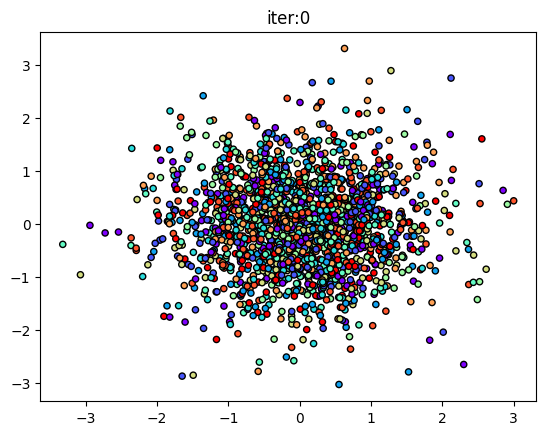

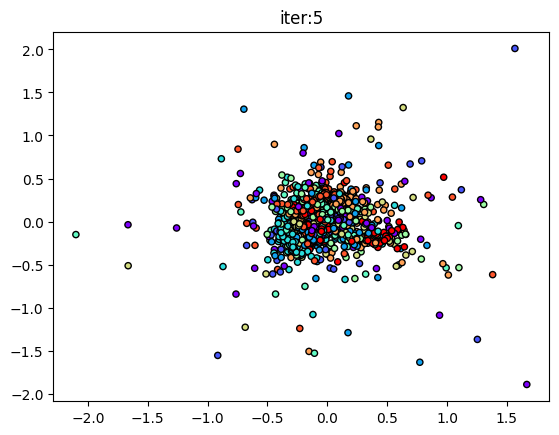

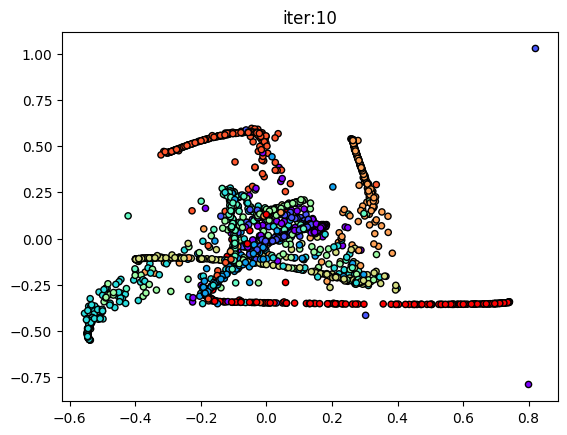

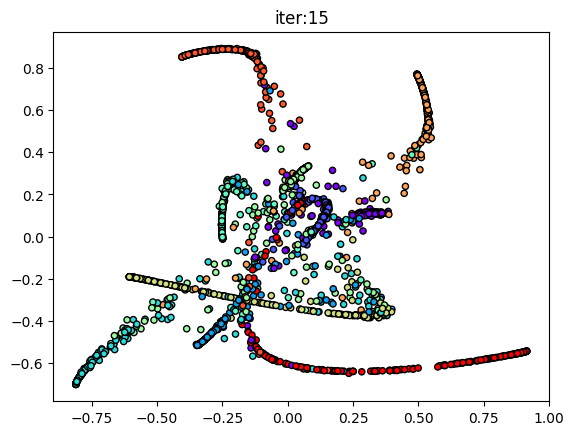

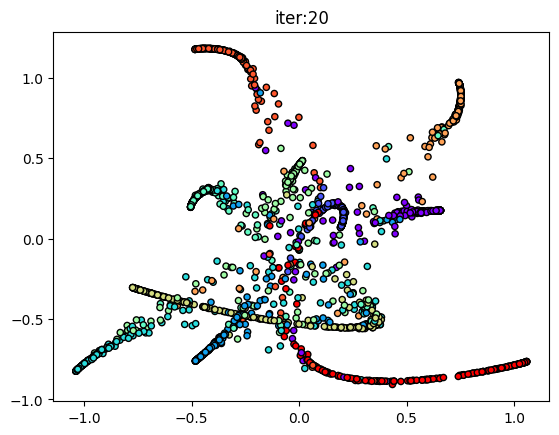

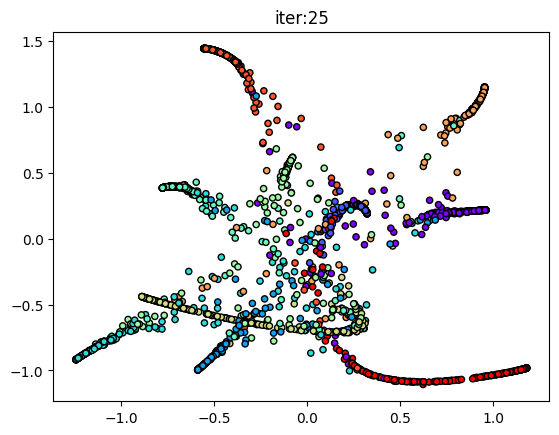

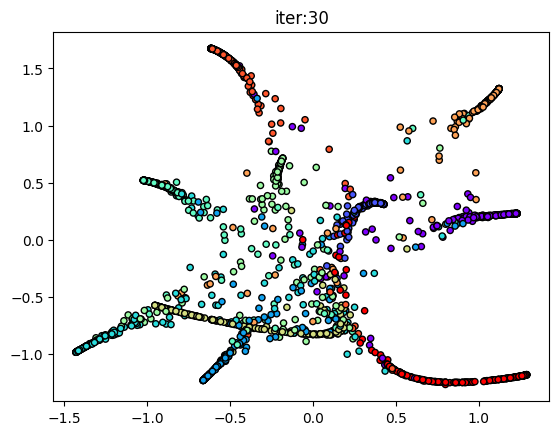

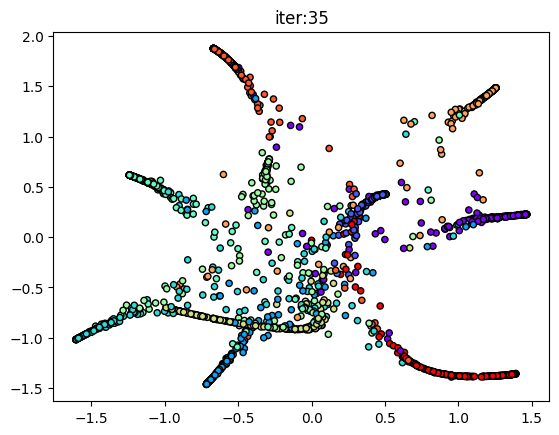

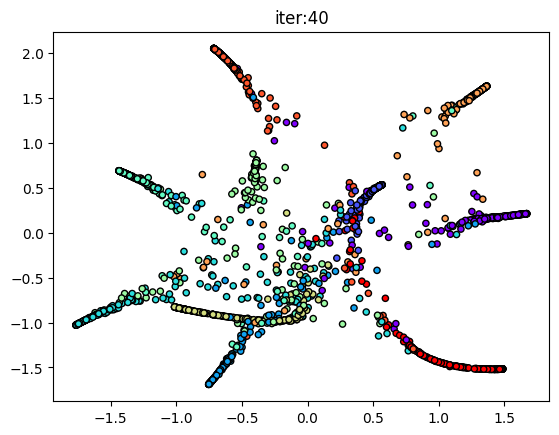

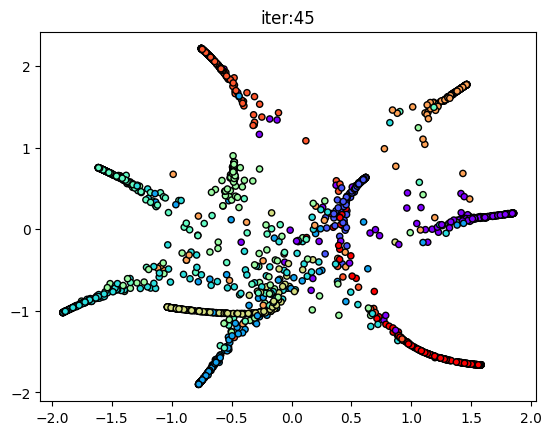

Iteration  50 : error is  1.8686145311341222


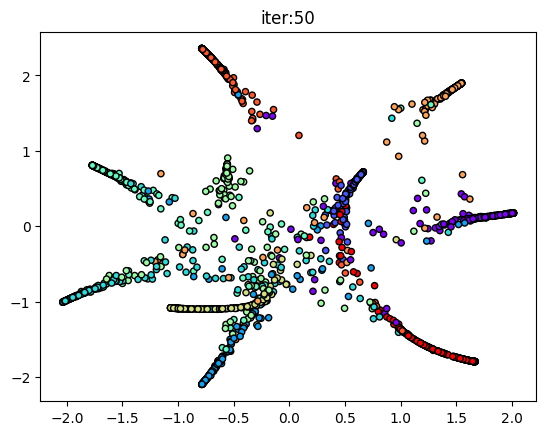

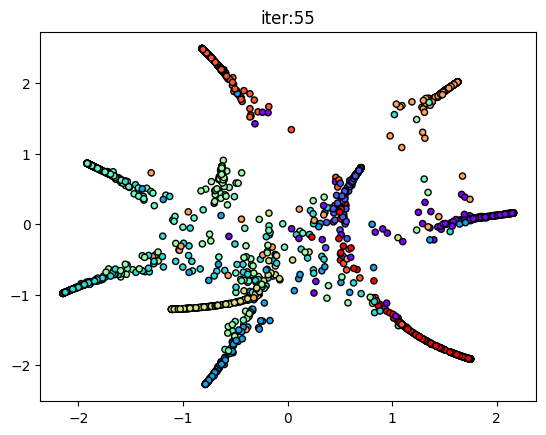

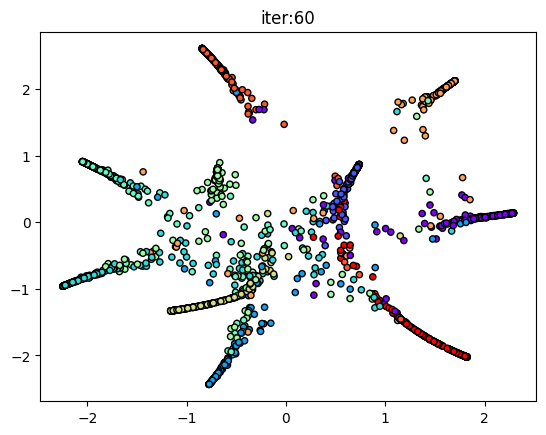

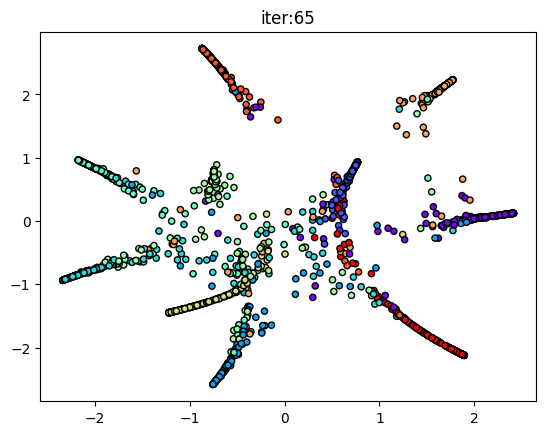

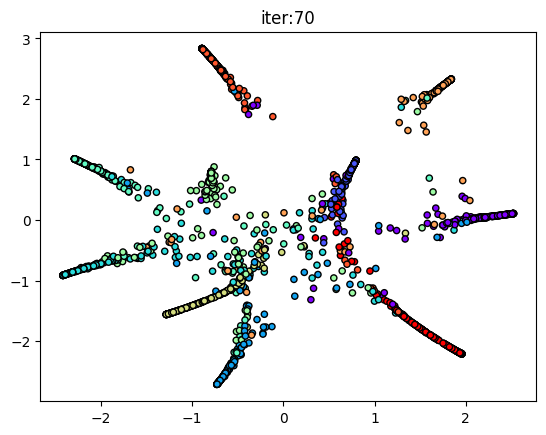

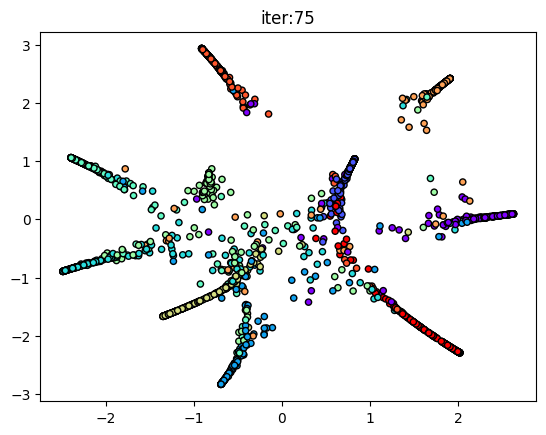

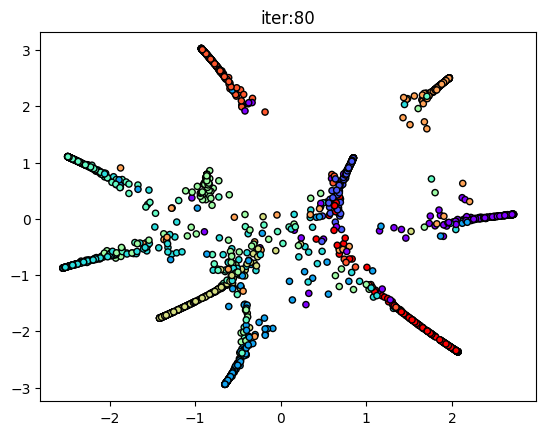

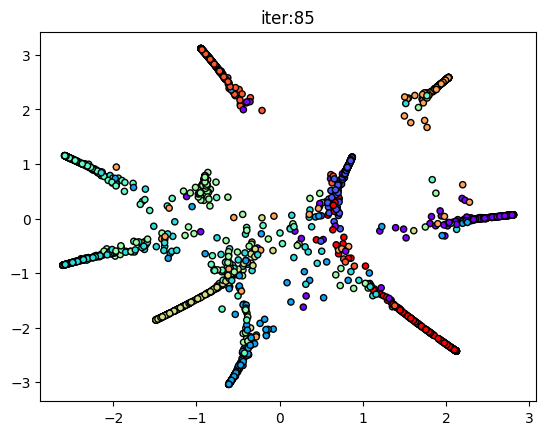

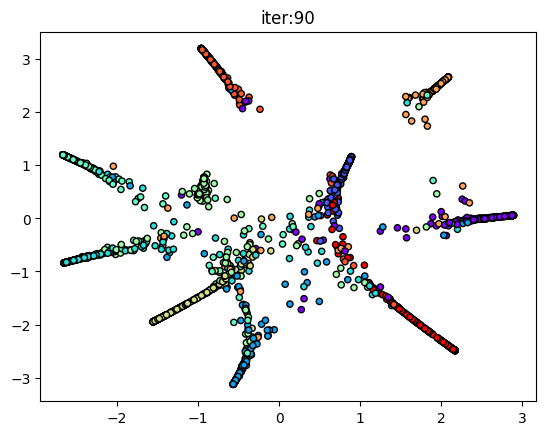

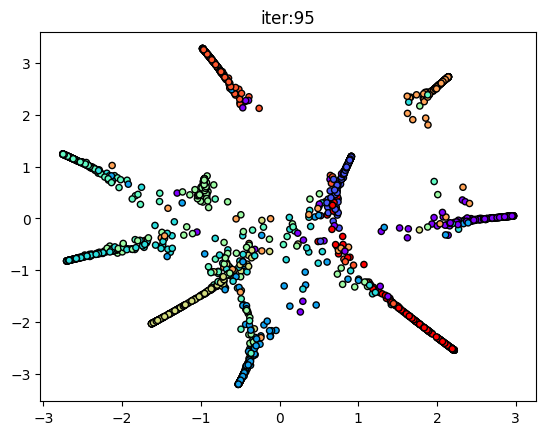

Iteration  100 : error is  1.4857861540636392


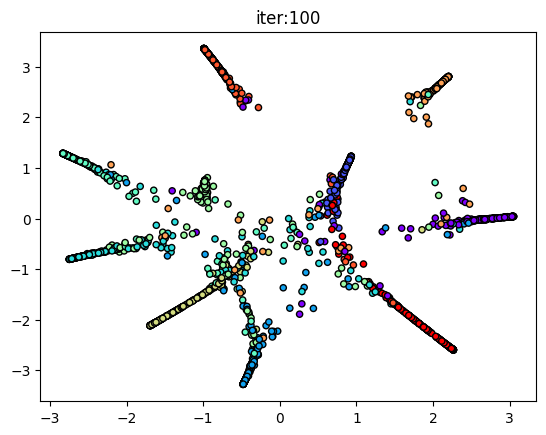

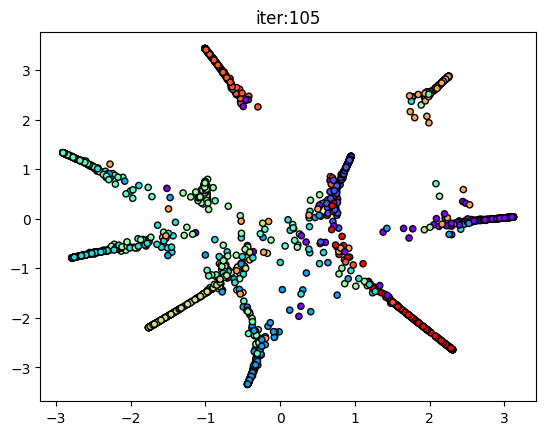

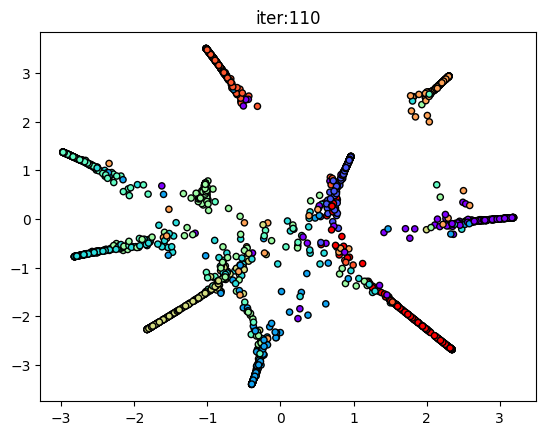

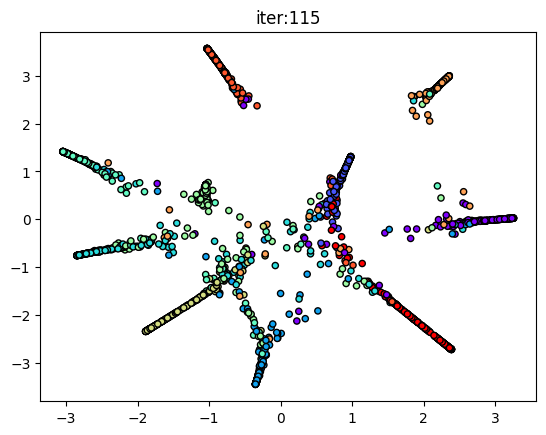

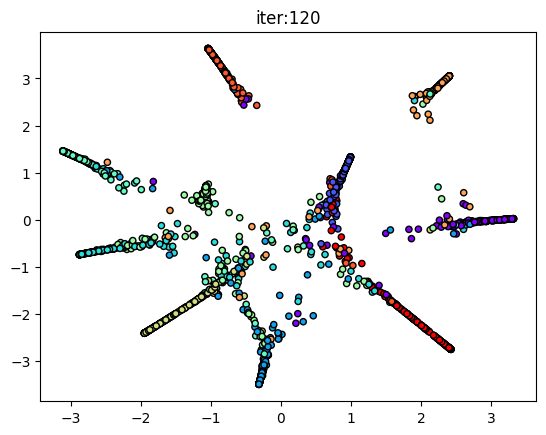

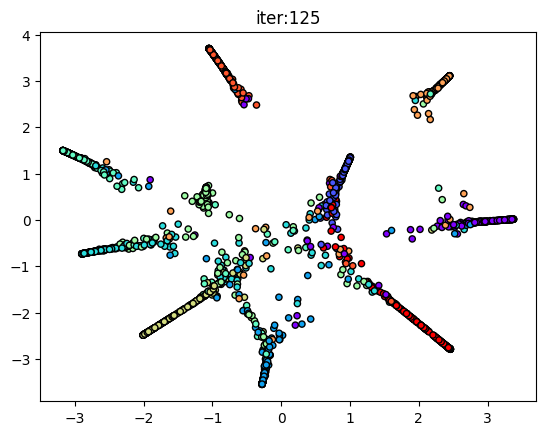

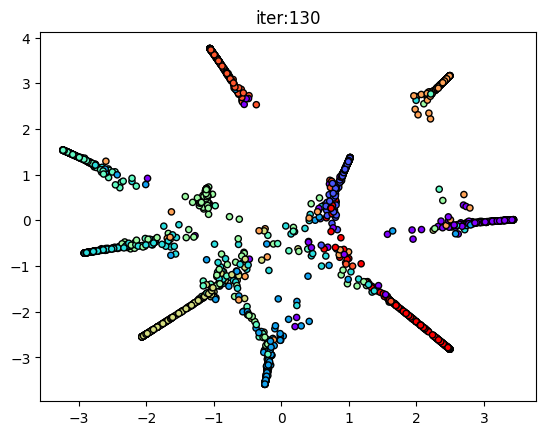

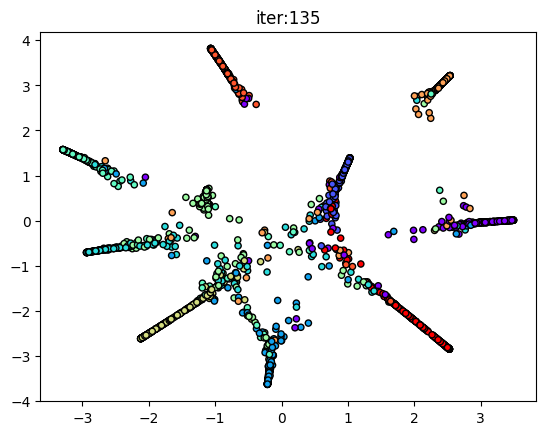

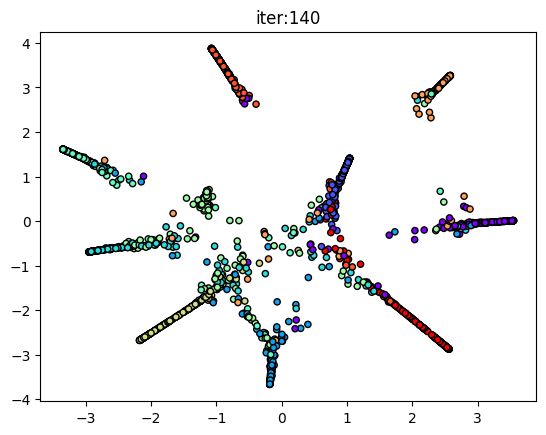

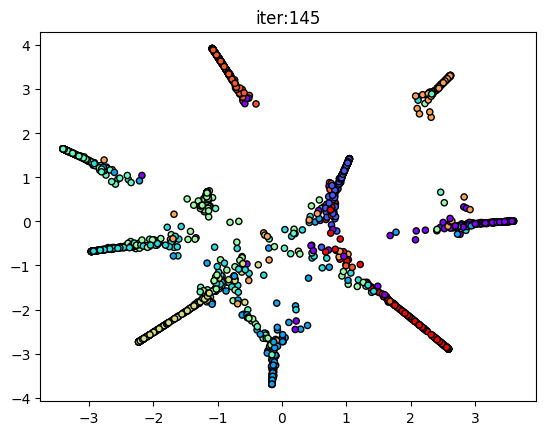

Iteration  150 : error is  10.86159116434928


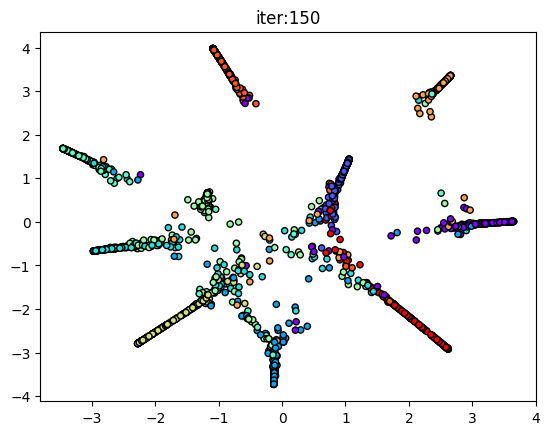

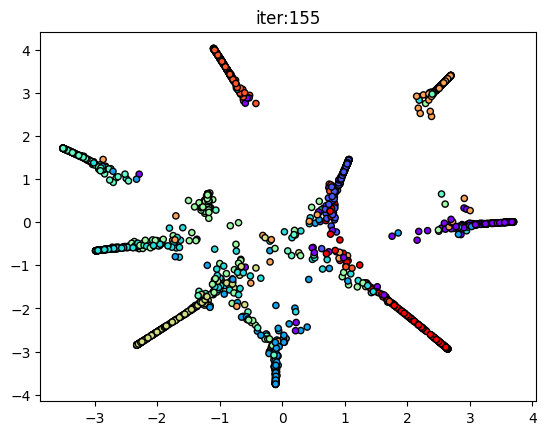

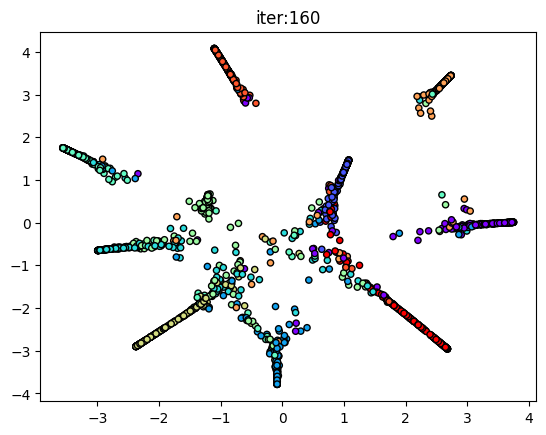

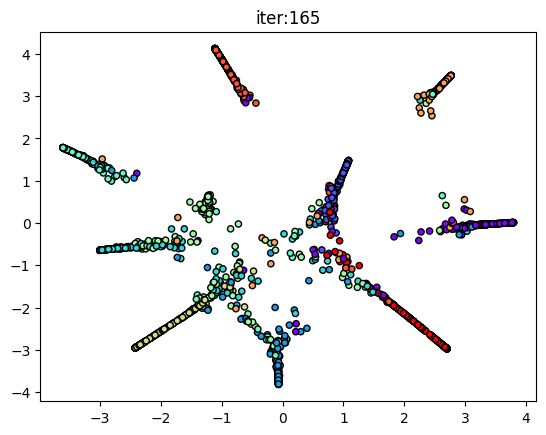

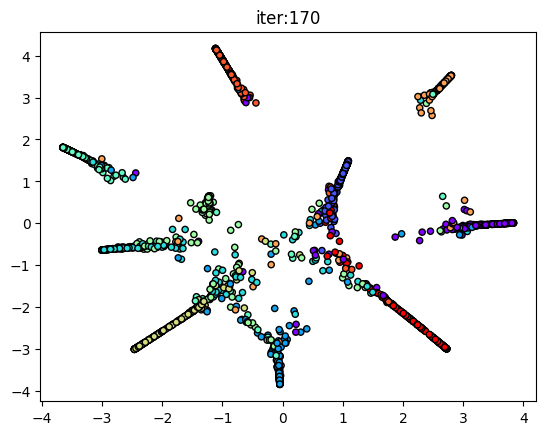

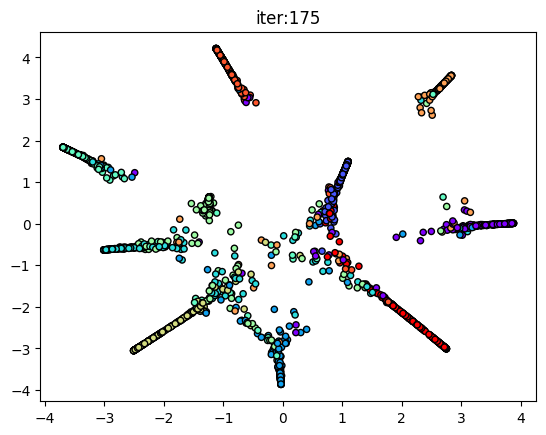

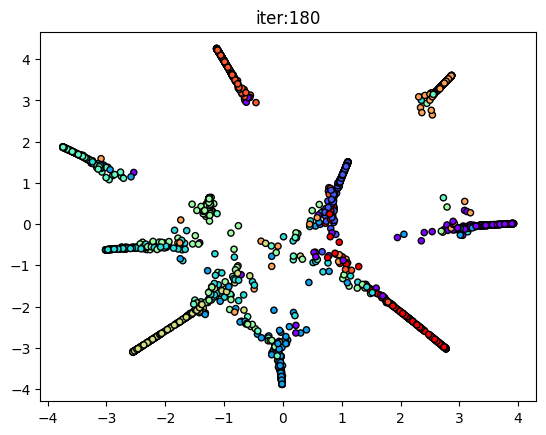

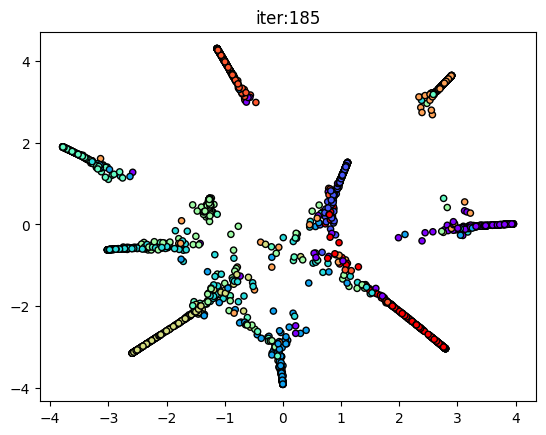

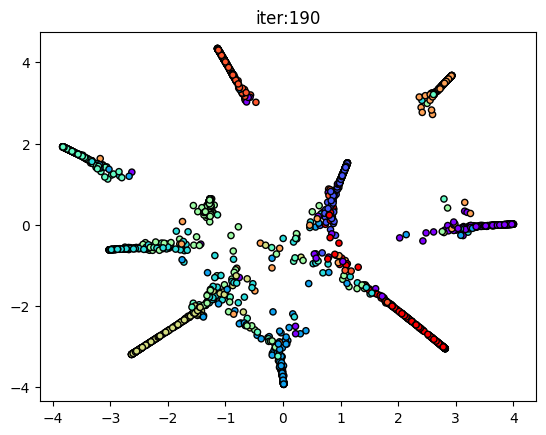

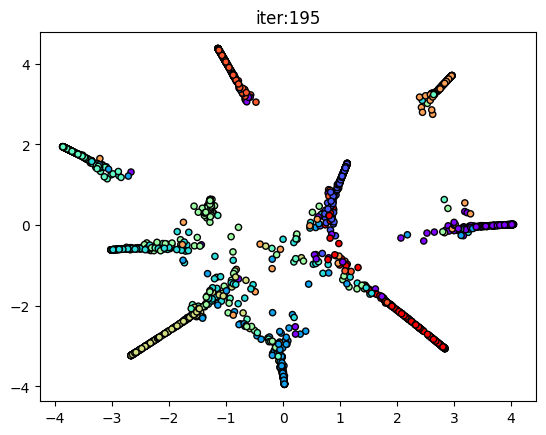

Iteration  200 : error is  10.525923721554832


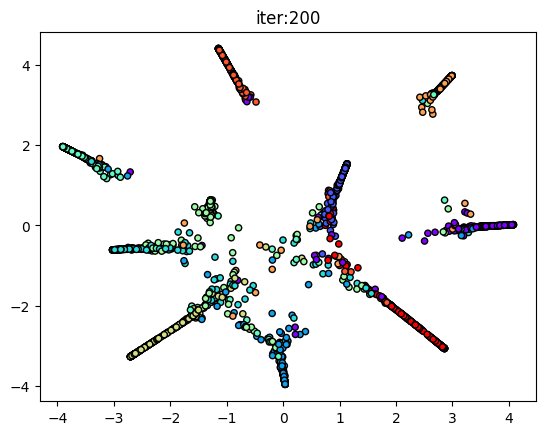

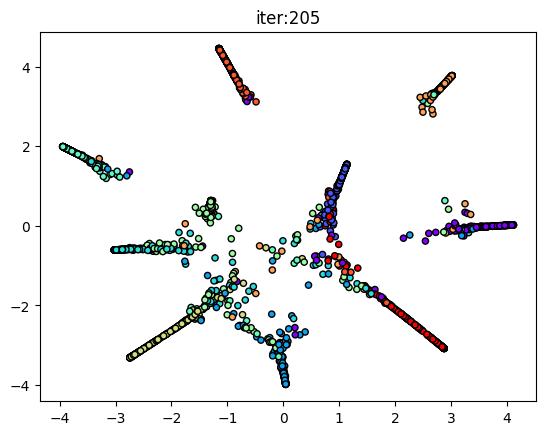

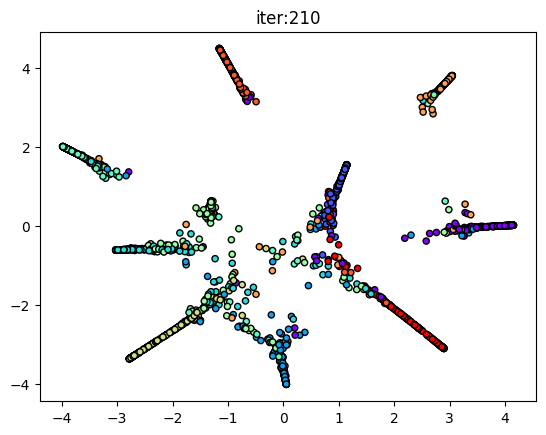

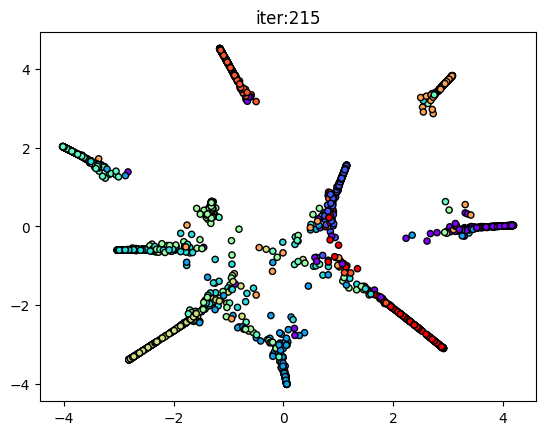

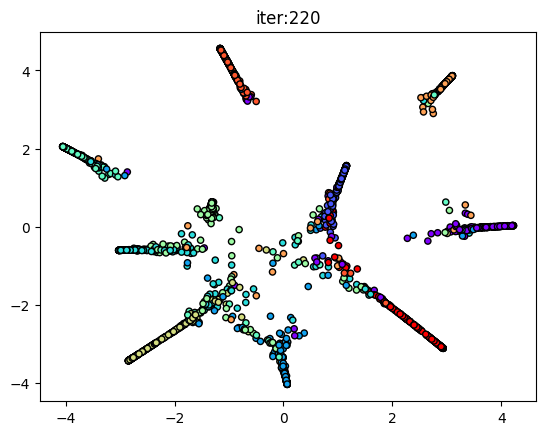

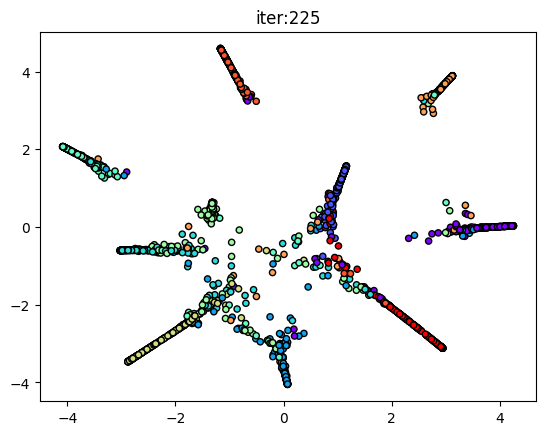

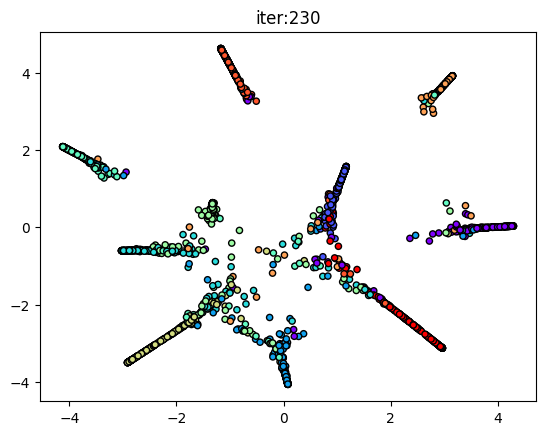

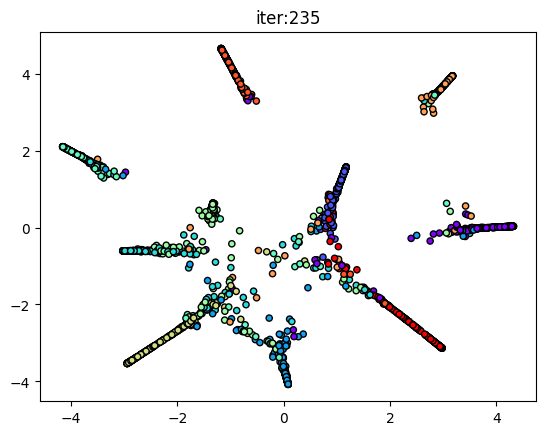

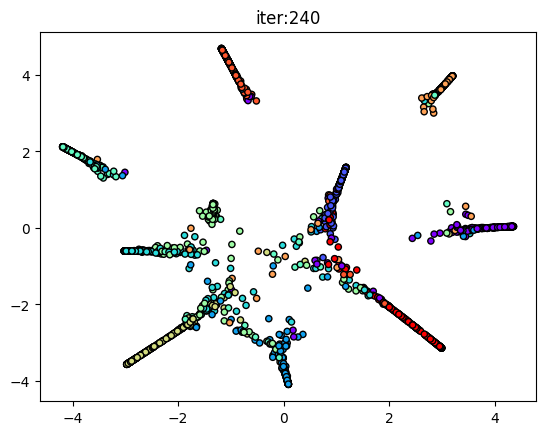

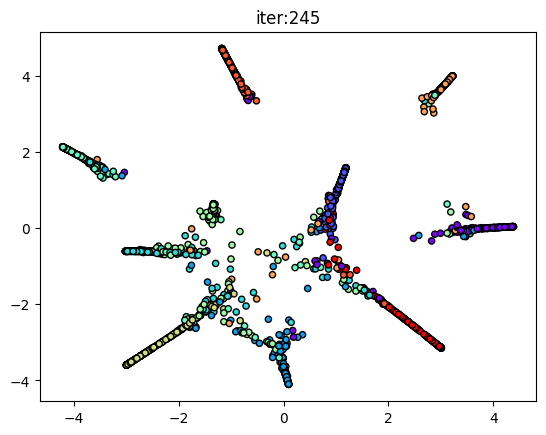

Iteration  250 : error is  10.31743345923292


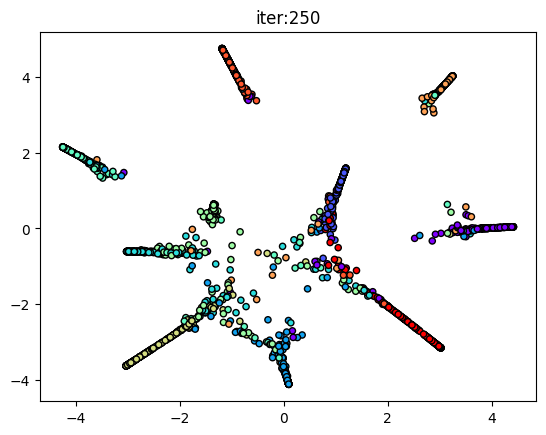

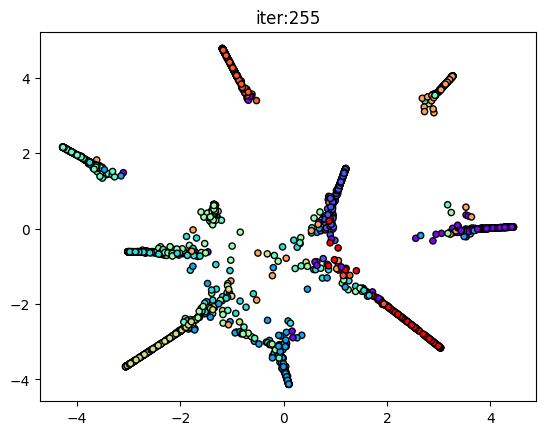

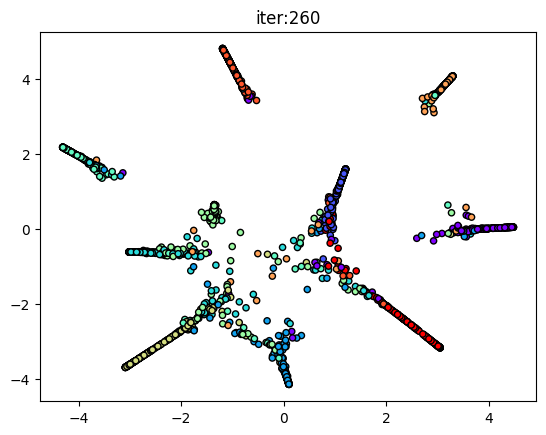

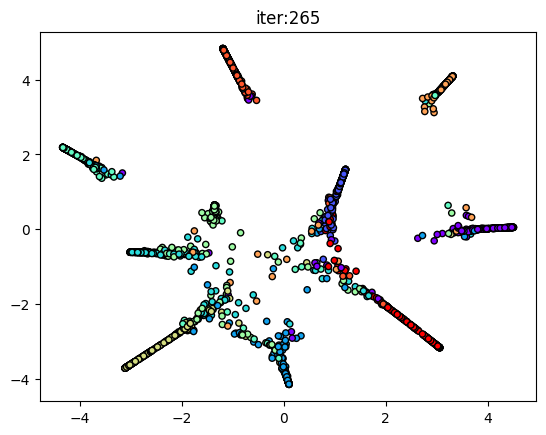

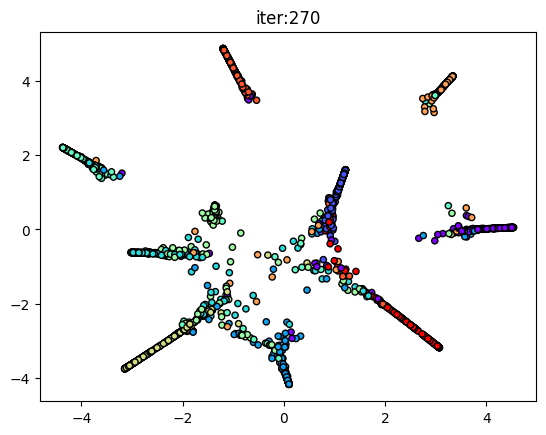

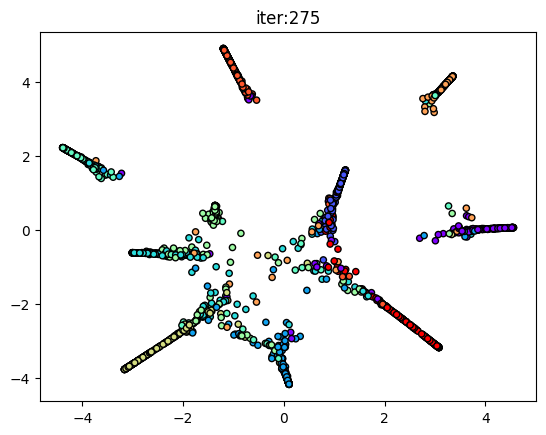

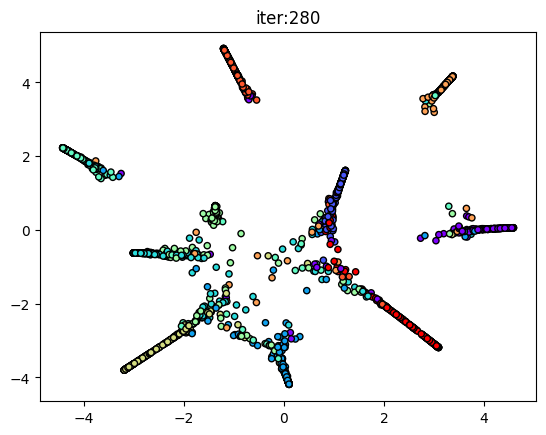

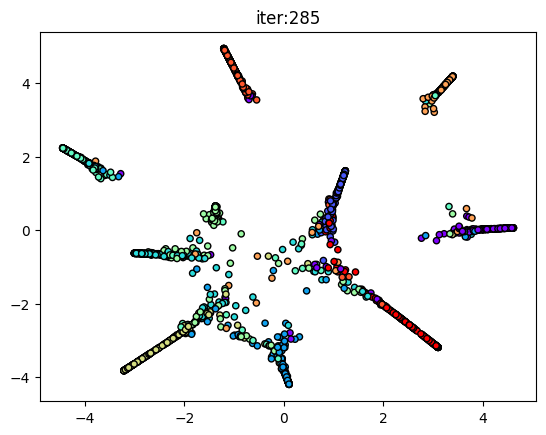

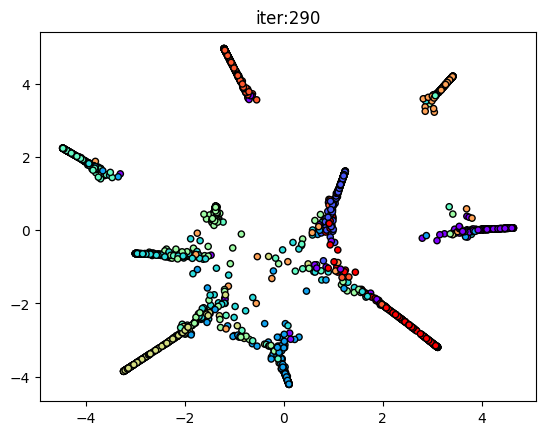

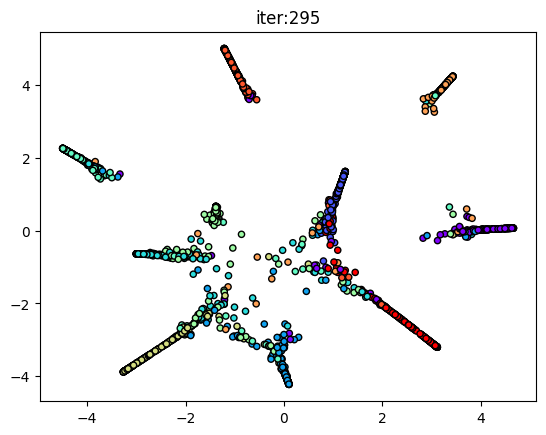

Iteration  300 : error is  10.174506816471172
finished training!
程序运行时间: 190.6921033859253 秒


In [12]:
import time

start_time = time.time()
Y = tsne(feature, no_dims=2, perplexity=80)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"程序运行时间: {elapsed_time} 秒")

# plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='rainbow', s=20, edgecolors='k')
# plt.show()